In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# datos

**usarios con Depresión**

In [ ]:
archivo = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con depresión/User_depresion (1).tsv'
ansiedad = pd.read_csv(archivo, sep ='\t')
ansiedad.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT
0,1,820809508935049216,"Soy de esas que escuchan canciones tristes, cu..."
1,1,779730304500011008,Latest Stats = 11 Followers and 3 Unfollowers ...
2,1,772600684478926849,RT @chicosuicidamas: Me canse de ser fuerte.
3,1,805186101413560321,"En el agua donde centro mis emociones, todo el..."
4,1,815302056533774336,RT @MrMenteSuicida: Es lindo cuando después de...
5,1,658016589053345792,RT @_HappyDark_: Mírame a los ojos.\nAquí es d...
6,1,946718429825961985,Un brindis por ese lugar vacío en la mesa
7,1,758339344209965056,RT @Chicosuicidamas: Cuando un verdadero amigo...
8,1,868645902680027136,RT @Chicobip0lar: https://t.co/gC49F6naPP
9,1,820464030468939777,Cuando le dije a mi mejor amiga que me autolas...


**Usarios de control**

In [ ]:
archivo_c = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/User_control (1).tsv'
control = pd.read_csv(archivo, sep ='\t')
control.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT
0,1,820809508935049216,"Soy de esas que escuchan canciones tristes, cu..."
1,1,779730304500011008,Latest Stats = 11 Followers and 3 Unfollowers ...
2,1,772600684478926849,RT @chicosuicidamas: Me canse de ser fuerte.
3,1,805186101413560321,"En el agua donde centro mis emociones, todo el..."
4,1,815302056533774336,RT @MrMenteSuicida: Es lindo cuando después de...
5,1,658016589053345792,RT @_HappyDark_: Mírame a los ojos.\nAquí es d...
6,1,946718429825961985,Un brindis por ese lugar vacío en la mesa
7,1,758339344209965056,RT @Chicosuicidamas: Cuando un verdadero amigo...
8,1,868645902680027136,RT @Chicobip0lar: https://t.co/gC49F6naPP
9,1,820464030468939777,Cuando le dije a mi mejor amiga que me autolas...


**PREPARACIÓN DE DATOS**

*Cargar y limpiar*

In [ ]:
!pip install pyspellchecker
!pip install spacy
!python -m spacy download es_core_news_sm

In [ ]:
import string
import re
import os
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# limpiar texto y Crear Tokens

In [ ]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def load_doc(filename):
    try:
        data = pd.read_csv(filename, delimiter='\t')  # Indicamos el delimitador como '\t' para TSV
        return data
    except Exception as e:
        print("Error:", e)
        return None

#Creamos un función de limpieza del texto y  los guarde en tokens indivicuales o lista de palabras
def clean_doc(text):
    # Eliminar hashtags
    text = re.sub(r'#\w+', '', text)

    # Eliminar URLs o enlaces
    text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

    # Eliminar nombres de usuarios de Twitter
    text = re.sub(r'@\w+', '', text)

    # Eliminar Nombres propios
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

    # Eliminar todos los caracteres especiales
    text = re.sub(r'[^\w\s]+', '', text)

    # Eliminar prefijos y números
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

    # Eliminar palabras específicas
    specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                      'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                      'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                      'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                      'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                      'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                      'it','we','they','the','and','that','these','those','tweet','followed','follower']
    text = ' '.join([word for word in text.split() if word not in specific_words])

    # Eliminar emojis
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                 '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                 ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')

    # Convertir el texto a minúsculas
    text = text.lower()

    # Eliminar signos de puntuación
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Tokenización de palabras
    tokens = word_tokenize(text)

    # Eliminar palabras vacías en español
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if not word in stop_words]

    # Eliminar tokens de un solo carácter
    tokens = [word for word in tokens if len(word) > 1]

    return tokens


*Extraer y Definir vocabulario*

In [ ]:
def add_doc_vocab_from_tsv(filename, vocab):
    data = pd.read_csv(filename, sep='\t')  # Especificamos el separador como '\t' para archivos TSV
    tokens_list = data['TWEET_TEXT'].apply(clean_doc)
    for tokens in tokens_list:
        vocab.update(tokens)

# Función para procesar documentos en un directorio a partir de archivos TSV
def process_docs_in_directory(directory, vocab):
    for filename in os.listdir(directory):
        if filename.endswith(".tsv"):  # Verificamos si el archivo tiene extensión .tsv
            path = os.path.join(directory, filename)
            add_doc_vocab_from_tsv(path, vocab)

In [ ]:
# Inicializar el contador de vocabulario
vocab = Counter()
# Procesar documentos en el directorio 'Control'
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab)
# Procesar documentos en el directorio 'Depresión'
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Depresión/', vocab)
# Imprimir la longitud del vocabulario y los 50 tokens más comunes
print(f'Tokens totales: {len(vocab)}')
print('los 50 Tokens más frecuentes')
print(vocab.most_common(50))


Tokens totales: 100384
los 50 Tokens más frecuentes
[('día', 9230), ('ser', 5066), ('vida', 4335), ('hoy', 4253), ('fotos', 4194), ('mejor', 4016), ('años', 3727), ('bien', 3657), ('días', 3531), ('así', 3368), ('mas', 3347), ('recuperar', 3340), ('preocupes', 3281), ('ver', 3276), ('hace', 3257), ('siempre', 3250), ('antigua', 3241), ('mostraré', 3227), ('laptop', 3224), ('hacer', 3001), ('gente', 2852), ('solo', 2827), ('hermosa', 2793), ('quiero', 2776), ('tan', 2731), ('vez', 2671), ('mañana', 2513), ('ahora', 2449), ('puede', 2393), ('voy', 2375), ('amor', 2359), ('https', 2315), ('personas', 2300), ('mundo', 2291), ('cosas', 2254), ('nunca', 2131), ('dos', 2128), ('mal', 2106), ('saludos', 2092), ('vía', 2060), ('partido', 2059), ('tiempo', 2046), ('semana', 1977), ('vivir', 1973), ('año', 1969), ('vos', 1961), ('cómo', 1927), ('gracias', 1918), ('alguien', 1873), ('país', 1860)]


In [ ]:
#Reducimos el numero de tokens eliminando Tokens que solo tengan 2 o menos frecuencia en las bases de datos
umbral = 10 # elimanamos la palabras que tengan 50 o menos frecuencia
tokens =[k for k,c in vocab.items() if c >= umbral]
print(len(tokens))

13509


In [ ]:
# Función para guardar los tokens en una lista de palabras
#guardar archivo preparado
def save_list(lines, filename):
  data = '\n'.join(lines)
  file = open(filename,'w')
  file.write(data)
  file.close()

In [ ]:
#Guardar los tokens en una lista de palabra o bolsa de palabras en un archivo llamdo vocab.txt
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# Inicializar el contador de vocabulario
vocab = Counter()
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab)
# Procesar documentos en el directorio 'Ansiedad'
process_docs_in_directory('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Depresión/', vocab)
print(f'Vocabulario: {len(vocab)}')
umbral = 10 # elimanamos la palabras que tengan 10 o menos frecuencia
tokens =[k for k,c in vocab.items() if c >= umbral]
print(f'Vocabulario con tokens más frecuentes:{len(tokens)}')

#Guardar la lista de Vocabulario con los tokens más frecuentes
save_list(tokens, '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt')


Vocabulario: 100384
Vocabulario con tokens más frecuentes:13509


In [ ]:
archivo = open("/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt")
print(archivo.read())

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")
# Función para lematizar y extraer términos

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def extractTerms(text):
    # Tokenización y lematización con spaCy
    doc = nlp(text)
    lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

    return lemmatized_terms

**Representación de bolsa de palabras (representación vectorial)**

*Revisiones a Lineas de Tokens*

In [ ]:
def doc_to_line(filename, vocab):
  doc = load_doc(filename)
  tokens = clean_doc(doc)
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)

In [ ]:
import os
import pandas as pd
from nltk.classify.senna import path

def process_docs(directory, vocab):
    lines = []
    for filename in os.listdir(directory):
        if not filename.endswith('.tsv'):
            continue
        path = os.path.join(directory, filename)

        # Cargar el archivo TSV en un DataFrame
        data = pd.read_csv(path, sep='\t')  # Usamos sep='\t' para especificar que el archivo es tsv

        # Procesar la columna TWEET_TEXT para obtener los tokens
        tokens_list = data['TWEET_TEXT'].apply(clean_doc)
        #tokens_list = data['TWEET_TEXT'].apply(extractTerms)

        for tokens in tokens_list:
            line = ' '.join(tokens)
            lines.append(line)

    return lines

In [ ]:
def load_clean_dataset(vocab):
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/',vocab)
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con depresión/',vocab)

  docs = Dep + Cont

  labels = [1 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))]
  return docs, labels

In [ ]:
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt'
with open(vocab_filename, 'r') as file:
    vocab_content = file.read()

vocab = vocab_content.split()
vocab = set(vocab)
print(vocab)


*Revisiones de los tweets a vectores de bolsa de palabras*

In [ ]:
# implementamos todo pero usando directamente las funciones creadas
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

docs, labels = load_clean_dataset(vocab)
print(len(docs), len(labels))

428792 428792


**Convertir y tranformar el documento a vectores codigicados**

In [ ]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        if is_train and filename.startswith('(72)'):
            continue  # Omitir archivos de prueba en el conjunto de entrenamiento
        if not is_train and not filename.startswith('(72)'):
            continue  # Omitir archivos de entrenamiento en el conjunto de prueba
        path = os.path.join(directory, filename)
        doc = load_doc(path)
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

In [ ]:
#Del mismo modo, la función load_clean_dataset() debe actualizarse para cargar el entrenamiento o prueba
# y asegúrarse de que devuelva una matriz Numpy
def load_clean_dataset(vocab, is_train):
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con depresión/', vocab, is_train)
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab, is_train)
  docs = Dep + Cont
  labels = np.array([1] * len(Dep) + [0] * len(Cont))
  return docs, labels

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isfile(path):  # Verificar si es un archivo antes de procesarlo
            doc = load_doc(path)
            line = ' '.join(clean_doc(doc))
            lines.append(line)
    return lines

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text


**Modelo análisis de texto**

In [ ]:
import os
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Cargar los datos limpios (entrenamiento y prueba)
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, y = load_clean_dataset(vocab, True)
test_docs, y_test = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)
x = tokenizer.texts_to_matrix(train_docs, mode='binary')
x_test = tokenizer.texts_to_matrix(test_docs, mode='binary')


# Dividir los datos en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(126, 122897)
(54, 122897)
(126,)
(54,)


#Redución de dimensionalidad con LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Aplicar LDA para reducir la dimensionalidad
n_topics = 70  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train = lda.fit_transform(X_train, y_train)
X_val = lda.transform(X_val)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(126, 70)
(54, 70)
(126,)
(54,)


In [ ]:
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

Epoch 1/100
3/3 [==============================] - 1s 118ms/step - loss: 0.6817 - accuracy: 0.5952 - val_loss: 0.6670 - val_accuracy: 0.5185
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6549 - accuracy: 0.6429 - val_loss: 0.6507 - val_accuracy: 0.5370
Epoch 3/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6340 - accuracy: 0.6905 - val_loss: 0.6341 - val_accuracy: 0.5370
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 0.6133 - accuracy: 0.7143 - val_loss: 0.6127 - val_accuracy: 0.6111
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5893 - accuracy: 0.7619 - val_loss: 0.5827 - val_accuracy: 0.6852
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.5652 - accuracy: 0.8095 - val_loss: 0.5486 - val_accuracy: 0.7222
Epoch 7/100
3/3 [==============================] - 0s 20ms/step - loss: 0.5365 - accuracy: 0.8333 - val_loss: 0.5096 - val_accuracy: 0.8519
Epoch 8/100
3/3 [==

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 97.0%
Precisión (entrenamiento): 96.0%
Recall (entrenamiento): 98.0%
F1-score (entrenamiento): 97.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 93.0%
Precisión en el conjunto de validación: 89.0%
Recall en el conjunto de validación: 96.0%
F1-score en el conjunto de validación: 92.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

2/2 [==============================] - 0s 7ms/step
Matriz de confusión: 

 [[26  3]
 [ 1 24]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.50


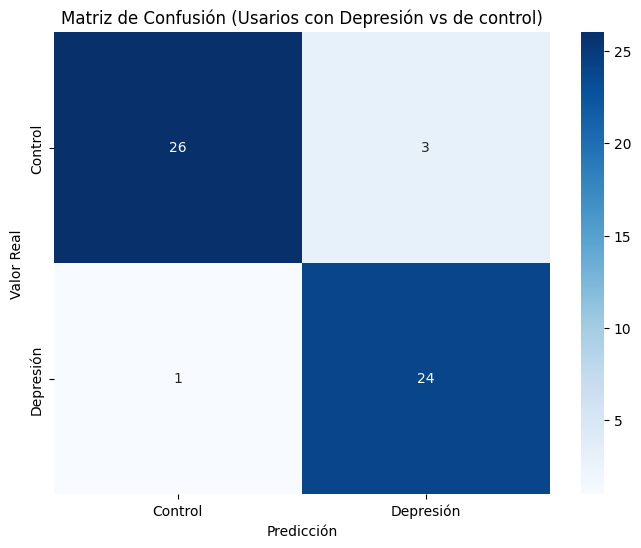

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo Arbol Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importa las librerías necesarias y divide los datos en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=300,  # Numero de alboles
                                             max_depth=100, # profunidad máxima
                                             random_state=42)  # selección de la semilla de manera aleatoria


# Entrena el modelo en los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula la precisión (accuracy) del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy (validación): {:.2f}".format(accuracy))

# Calcula la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred)
print("Precision (validación): {:.2f}".format(precision))

# Calcula la exactitud (recall) del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred)
print("Recall (validación): {:.2f}".format(recall))

# Calcula el F1-score del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred)
print("F1-score (validación): {:.2f}".format(f1))

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

#




Accuracy (validación): 0.89
Precision (validación): 1.00
Recall (validación): 0.76
F1-score (validación): 0.86


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 100.00%
Precisión  entrenamiento: 100.00%
Recall  entrenamiento: 100.00%
Puntuación F1  entrenamiento: 100.00%


Accuracy  validación: 88.89%
Precisión  validación: 100.00%
Recall  validación: 76.00%
Puntuación F1 validación: 86.36%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = random_forest_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[29  0]
 [ 6 19]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.35


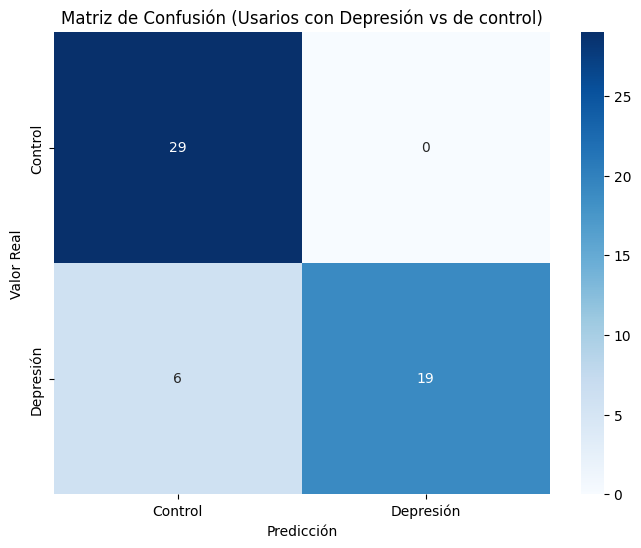

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

svm_model_p = SVC(kernel='linear', degree=4, C=100, probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcula la precisión del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)


# Calcula precisión, exhaustividad y puntuación F1 en el conjunto de validación
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nEntrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))
print("\nValidación:")
print(f"Exactitud en el conjunto de validación: {round(accuracy,2)*100}%")
print(f"Precisión en el conjunto de validación:{round(precision,2)*100}%")
print(f"Recall en el conjunto de validación: {round(recall,2)*100}%")
print(f"F1-score en el conjunto de validación:{round(f1,2)*100}%")




Entrenamiento:
Exactitud (entrenamiento): 90.48%
Precision (entrenamiento): 88.41%
Recall (entrenamiento): 93.85%
F1-score (entrenamiento): 91.04%

Validación:
Exactitud en el conjunto de validación: 87.0%
Precisión en el conjunto de validación:80.0%
Recall en el conjunto de validación: 96.0%
F1-score en el conjunto de validación:87.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[23  6]
 [ 1 24]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.56


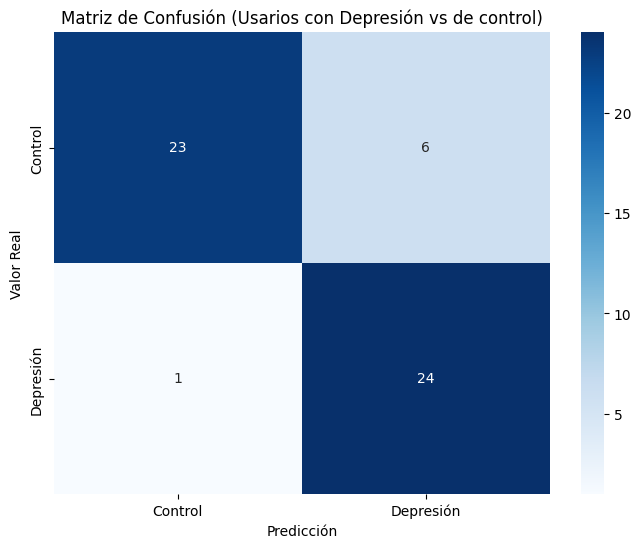

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

# **Regresión Logistica**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
# Crear el modelo de regresión logística
lr_model = LogisticRegression(C=10)
lr_model.fit(X_train, y_train)

# Calcular el porcentaje de acierto en el conjunto de entrenamiento
accuracy_train = lr_model.score(X_train, y_train) * 100

# Calcular el porcentaje de acierto en el conjunto de validación
accuracy_val = lr_model.score(X_val, y_val) * 100

# Predicciones en el conjunto de entrenamiento y validación
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calcular precisión en el conjunto de entrenamiento y validación
precision_train = precision_score(y_train, y_train_pred)* 100
precision_val = precision_score(y_val, y_val_pred)* 100

# Calcular exhaustividad (recall) en el conjunto de entrenamiento y validación
recall_train = recall_score(y_train, y_train_pred)* 100
recall_val = recall_score(y_val, y_val_pred)* 100

# Calcular puntuación F1 en el conjunto de entrenamiento y validación
f1_train = f1_score(y_train, y_train_pred)* 100
f1_val = f1_score(y_val, y_val_pred)* 100


In [ ]:
# Mostrar métricas de entrenamiento
print("Métricas de entrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train))
print("Precisión (entrenamiento): {:.2f}%".format(precision_train))
print("Exhaustividad (entrenamiento): {:.2f}%".format(recall_train))
print("Puntuación F1 (entrenamiento): {:.2f}%".format(f1_train))
print('-'*40)
# Mostrar métricas de validación
print("\nMétricas de validación:")
print("Exactitud (validación): {:.2f}%".format(accuracy_val))
print("Precisión (validación): {:.2f}%".format(precision_val))
print("Exhaustividad (validación): {:.2f}%".format(recall_val))
print("Puntuación F1 (validación): {:.2f}%".format(f1_val))

Métricas de entrenamiento:
Exactitud (entrenamiento): 83.33%
Precisión (entrenamiento): 78.21%
Exhaustividad (entrenamiento): 93.85%
Puntuación F1 (entrenamiento): 85.31%
----------------------------------------

Métricas de validación:
Exactitud (validación): 88.89%
Precisión (validación): 80.65%
Exhaustividad (validación): 100.00%
Puntuación F1 (validación): 89.29%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = lr_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[23  6]
 [ 0 25]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.57


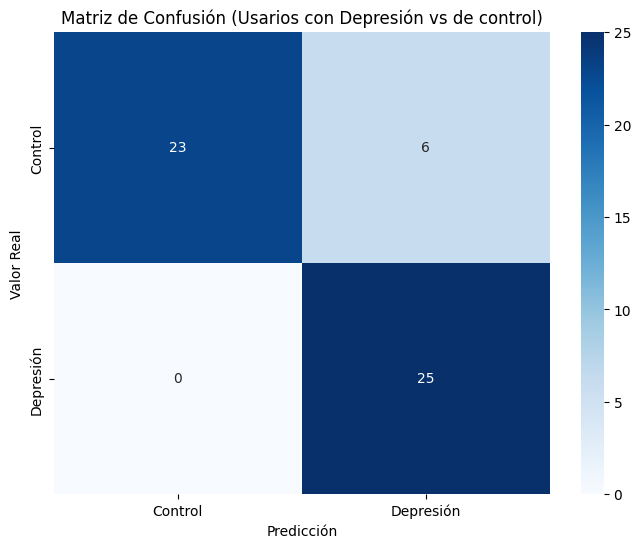

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()